# code runs!<br>
do final clean and add ROC

In [1]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from tqdm import tqdm

import json
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
from sklearn import tree

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') 
path = '/content/gdrive/MyDrive/IFT 6390/kaggle2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
tqdm.pandas()

### read and prep data

In [4]:
input_path = path+'data/input/'

In [5]:
all_train_data = pd.read_csv(input_path + 'train_data_prepped.csv').fillna('')
all_test_data = pd.read_csv(input_path + 'test_data_prepped.csv').fillna('')

In [6]:
train_target = pd.read_csv(input_path + 'train_results.csv')
train_target['target'].value_counts()

positive    520436
negative    519803
neutral         84
Name: target, dtype: int64

In [7]:
train_target['target'] = [0 if t == 'negative' else 2 if t == 'positive' else 2 for t in train_target['target'].values]

In [8]:
all_train_data['target'] = train_target['target']

In [9]:
all_train_data['target'].value_counts()

2    520520
0    519803
Name: target, dtype: int64

### establish parameters

In [62]:
vocab_sizes = [100, 1_000, 10_000]
ngrams = [(1, 1), (2, 2), (1, 2)]
text_columns = ['text_no_numerals', 'text_no_sw', 'text_lancaster_stemmed', 'text_lemmatized']
vectorizers = [TfidfVectorizer, CountVectorizer]
models = [DecisionTreeClassifier()]


set decision tree parameters

In [63]:
param_grid = {
    'criterion': ['gini',],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2', None],
    
}

In [44]:
def trainModels(train_data, targets, vocab_sizes, text_columns, ngrams, vectorizers, models, param_grid):
    param_tracker = []
    predictions_tracker = []
    counter = 1
    for size in tqdm(vocab_sizes):


        for col in text_columns:

            text = train_data[col]
            for ng in ngrams:

                for vectorizer in vectorizers:
                  
                    vectorizer_name = str(vectorizer).split('.')[-1].replace('>', '').replace("\'",'').strip()
                    print('vectorizer name: ', vectorizer_name)
                    vectorizer = vectorizer(max_features=size, ngram_range=ng)
                    print('vectorizer: ', vectorizer)



                    BOW = vectorizer.fit_transform(text)
        
                    print('BOW shape: ', BOW.shape)

                    X_train, X_valid, y_train, y_valid = train_test_split(BOW, targets, test_size=0.2, random_state=42)


                    for model in models:
                        model_name = str(model)
                        counter+=1
                        if counter % 10==0:
                            print(f'{counter}')

                        grid = RandomizedSearchCV(estimator = model,
                                         param_distributions=param_grid,
                                         scoring = 'accuracy',
                                         cv=3,
                                         n_iter=5,
                                         verbose=0)

                        grid.fit(X_train, y_train)

                        accuracy = grid.score(X_valid, y_valid)

                        grid_params = grid.best_params_
                        criterion = grid_params['criterion']
                        max_depth = grid_params['max_depth']
                        max_features = grid_params['max_features']
                        print('accuracy: ', accuracy, '\n')

                        model_params = {

                            'vocab_size': size,
                            'model_name': model_name,
                            'text_column': col,
                            'ngram': ng,
                            'vectorizer': vectorizer_name,
                            'splitting_criterion': criterion,
                            'tree_max_depth': max_depth,
                            'tree_max_features': max_features,
                            'accuracy': accuracy


                        }


                        param_tracker.append(model_params)


            

    return param_tracker



In [45]:
sample_size=10_000
v1_data = all_train_data.sample(sample_size)
v1_train_X = v1_data.iloc[:, :-1]
v1_train_y  = v1_data.iloc[:, -1]

In [48]:
param_tracker = trainModels(v1_train_X, v1_train_y, vocab_sizes, text_columns, ngrams, vectorizers, models, param_grid)

  0%|          | 0/3 [00:00<?, ?it/s]

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=100)
BOW shape:  (10000, 100)
accuracy:  0.5645 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=100)
BOW shape:  (10000, 100)
accuracy:  0.562 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=100, ngram_range=(2, 2))
BOW shape:  (10000, 100)
accuracy:  0.5295 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=100, ngram_range=(2, 2))
BOW shape:  (10000, 100)
accuracy:  0.531 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=100, ngram_range=(1, 2))
BOW shape:  (10000, 100)
accuracy:  0.5535 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=100, ngram_range=(1, 2))
BOW shape:  (10000, 100)
accuracy:  0.574 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=100, ngram_range=(1, 3))
BOW shape:  (10000, 100)
accuracy:  0.5655 

vectorizer name:  Cou

 33%|███▎      | 1/3 [00:28<00:57, 28.77s/it]

BOW shape:  (10000, 100)
accuracy:  0.559 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=1000)
BOW shape:  (10000, 1000)
accuracy:  0.567 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=1000)
BOW shape:  (10000, 1000)
accuracy:  0.555 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=1000, ngram_range=(2, 2))
BOW shape:  (10000, 1000)
accuracy:  0.531 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=1000, ngram_range=(2, 2))
BOW shape:  (10000, 1000)
accuracy:  0.5315 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
BOW shape:  (10000, 1000)
accuracy:  0.5515 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=1000, ngram_range=(1, 2))
BOW shape:  (10000, 1000)
accuracy:  0.5665 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=1000, ngram_range=(1, 3))
BOW shape

 67%|██████▋   | 2/3 [03:22<01:53, 113.90s/it]

accuracy:  0.5695 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=10000)
BOW shape:  (10000, 10000)
accuracy:  0.5655 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=10000)
BOW shape:  (10000, 10000)
accuracy:  0.569 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=10000, ngram_range=(2, 2))
BOW shape:  (10000, 10000)
accuracy:  0.4955 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=10000, ngram_range=(2, 2))
BOW shape:  (10000, 10000)
accuracy:  0.5305 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
BOW shape:  (10000, 10000)
accuracy:  0.564 

vectorizer name:  CountVectorizer
vectorizer:  CountVectorizer(max_features=10000, ngram_range=(1, 2))
BOW shape:  (10000, 10000)
accuracy:  0.5675 

vectorizer name:  TfidfVectorizer
vectorizer:  TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
BOW shape:  (10000,

100%|██████████| 3/3 [35:41<00:00, 713.76s/it]

accuracy:  0.567 



In [49]:
param_df = pd.DataFrame(param_tracker,)
param_df = param_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)


In [50]:
param_df.iloc[0]['vectorizer'].split('.')[-1].replace('>', '').replace("\'",'').strip()

'CountVectorizer(max_features=10000, ngram_range=(1, 3))'

saving and loading results

In [51]:
param_df.to_csv(path+'data/output/decision_tree/decision_tree_params.csv', index=False)


In [52]:
param_df = pd.read_csv(path+'data/output/decision_tree/decision_tree_params.csv')
param_df['ngram'] = [(int(ng[1]), int(ng[4])) for ng in param_df['ngram'].values]
param_df = param_df.replace({np.nan: None})
param_df.head(3)


,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy
0,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 3)","CountVectorizer(max_features=10000, ngram_rang...",gini,7,None,0.5790
1,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",CountVectorizer(max_features=10000),gini,7,None,0.5790
2,1000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 2)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5785


get best 20 combinations and train on more data

In [58]:
top_20_params = param_df[:20]

# for cross validation, num folds   
k = 3

In [68]:
sample_size=50_000
v2_data = all_train_data.sample(sample_size).reset_index(drop=True)
v2_train_X = v2_data.iloc[:, :-1]
v2_train_y  = v2_data.iloc[:, -1].values

0        2
1        2
2        2
3        0
4        2
        ..
49995    0
49996    0
49997    2
49998    2
49999    0
Name: target, Length: 50000, dtype: int64

In [69]:

model_accuracy = []
predictions = []
for i, param_set in enumerate(tqdm(top_20_params.values)):
    (vocab_size, 
     model_type, 
     text_column, 
     ngram, 
     vectorizer_name, 
     criterion, 
     max_depth,
     max_features, 
     *_) = param_set
    

    
    print(vocab_size, model_type, text_column, ngram, vectorizer, criterion, max_depth, max_features)
    
    if vocab_size:
        vocab_size = int(vocab_size)
        
    vectorizer = vectorizer_name.split('(')[0]
    if vectorizer == 'TfidfVectorizer':
        vectorizer = TfidfVectorizer
    elif vectorizer == 'CountVectorizer':
        vectorizer = CountVectorizer

    else:
        print('warning, unrecognized vectorizer!')
        print(i, param_set)
    
    print('vectorizing')
    model_vectorizer = vectorizer(max_features=vocab_size, ngram_range=ngram)

    print('creating BOW')
    
    BOW = model_vectorizer.fit_transform(v2_train_X[text_column])
   
    
    
    kfolds = KFold(n_splits=k)
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features)
    
    acc_score = []
    for train_index , valid_index in kfolds.split(BOW):
        X_train , X_valid = BOW[train_index,:],BOW[valid_index,:]
        y_train , y_valid = v2_train_y[train_index] , v2_train_y[valid_index]
        
        print('fitting fold')
        model.fit(X_train,y_train)
        pred_values = model.predict(X_valid)

        acc = accuracy_score(pred_values , y_valid)
        print('fold acc: ', acc)
        acc_score.append(acc)
        
        pred_probs = model.predict_proba(X_valid)

    mean_acc = sum(acc_score)/len(acc_score)
    
    print(mean_acc, '\n\n')
    model_accuracy.append(mean_acc)
    predictions.append(pred_probs)
    


  0%|          | 0/50 [00:00<?, ?it/s]

10000 DecisionTreeClassifier() text_porter_stemmed (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5839083218335633
fitting fold


  2%|▏         | 1/50 [00:05<04:36,  5.65s/it]

fold acc:  0.5922481550368993
fitting fold
fold acc:  0.5963638545541822
0.5908401104748816 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5842083158336834
fitting fold
fold acc:  0.5927881442371152
fitting fold


  4%|▍         | 2/50 [00:07<02:32,  3.18s/it]

fold acc:  0.5958838353534142
0.5909600984747376 


1000 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5850482990340193
fitting fold
fold acc:  0.5920681586368273


  6%|▌         | 3/50 [00:09<02:17,  2.92s/it]

fitting fold
fold acc:  0.5953438137525501
0.5908200904744656 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5845683086338274
fitting fold
fold acc:  0.5921881562368753
fitting fold


  8%|▊         | 4/50 [00:12<02:18,  3.02s/it]

fold acc:  0.5962438497539901
0.5910001048748975 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 3) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5845083098338033
fitting fold
fold acc:  0.5922481550368993
fitting fold


 10%|█         | 5/50 [00:18<02:51,  3.82s/it]

fold acc:  0.5964838593543742
0.5910801080750255 


100 DecisionTreeClassifier() text_no_numerals (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5762284754304914
fitting fold
fold acc:  0.5800683986320273
fitting fold
fold acc:  0.5859834393375735


 12%|█▏        | 6/50 [00:20<02:31,  3.45s/it]

0.5807601044666973 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5794084118317634
fitting fold
fold acc:  0.5860082798344033
fitting fold


 14%|█▍        | 7/50 [00:24<02:29,  3.48s/it]

fold acc:  0.592823712948518
0.5860801348715615 


100 DecisionTreeClassifier() text_no_numerals (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5756884862302754
fitting fold
fold acc:  0.5801283974320514
fitting fold


 16%|█▌        | 8/50 [00:29<02:51,  4.07s/it]

fold acc:  0.5859234369374775
0.5805801068666013 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW


 18%|█▊        | 9/50 [00:30<02:07,  3.11s/it]

fitting fold
fold acc:  0.5642287154256915
fitting fold
fold acc:  0.5771284574308514
fitting fold
fold acc:  0.561382455298212
0.567579876051585 


100 DecisionTreeClassifier() text_porter_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW


 20%|██        | 10/50 [00:33<01:57,  2.94s/it]

fitting fold
fold acc:  0.5620087598248035
fitting fold
fold acc:  0.5758084838303233
fitting fold
fold acc:  0.578663146525861
0.5721601300603293 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5806683866322674
fitting fold
fold acc:  0.5912881742365153
fitting fold


 22%|██▏       | 11/50 [00:35<01:40,  2.58s/it]

fold acc:  0.5915636625465018
0.5878400744717616 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5647687046259074
fitting fold


 24%|██▍       | 12/50 [00:40<02:14,  3.55s/it]

fold acc:  0.5760484790304194
fitting fold
fold acc:  0.562822512900516
0.567879898852281 


100 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5878682426351473
fitting fold
fold acc:  0.5843283134337314
fitting fold


 26%|██▌       | 13/50 [00:43<02:05,  3.40s/it]

fold acc:  0.5920436817472698
0.5880800792720494 


1000 DecisionTreeClassifier() text_lemmatized (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5749685006299874
fitting fold
fold acc:  0.5843883122337553
fitting fold


 28%|██▊       | 14/50 [00:50<02:32,  4.25s/it]

fold acc:  0.5898835953438137
0.5830801360691855 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 2) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5639287214255715
fitting fold


 30%|███       | 15/50 [00:52<02:14,  3.84s/it]

fold acc:  0.5767084658306834
fitting fold
fold acc:  0.561382455298212
0.567339880851489 


1000 DecisionTreeClassifier() text_lancaster_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5650686986260275
fitting fold
fold acc:  0.5759284814303713
fitting fold


 32%|███▏      | 16/50 [00:53<01:40,  2.97s/it]

fold acc:  0.562702508100324
0.5678998960522409 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5648287034259315
fitting fold


 34%|███▍      | 17/50 [00:56<01:35,  2.89s/it]

fold acc:  0.5761684766304674
fitting fold
fold acc:  0.5628825153006121
0.567959898452337 


100 DecisionTreeClassifier() text_lancaster_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 sqrt
vectorizing
creating BOW


 36%|███▌      | 18/50 [00:57<01:12,  2.27s/it]

fitting fold
fold acc:  0.5672886542269154
fitting fold
fold acc:  0.5828883422331553
fitting fold
fold acc:  0.578003120124805
0.5760600388616253 


100 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW


 38%|███▊      | 19/50 [00:59<01:11,  2.32s/it]

fitting fold
fold acc:  0.5624887502249954
fitting fold
fold acc:  0.5860082798344033
fitting fold
fold acc:  0.5786031441257651
0.5757000580617213 


1000 DecisionTreeClassifier() text_lemmatized (1, 3) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5666886662266755
fitting fold
fold acc:  0.5732885342293154
fitting fold


 40%|████      | 20/50 [01:05<01:36,  3.21s/it]

fold acc:  0.5810032401296051
0.5736601468618653 


1000 DecisionTreeClassifier() text_lemmatized (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5666886662266755
fitting fold
fold acc:  0.5731085378292434
fitting fold


 42%|████▏     | 21/50 [01:07<01:29,  3.07s/it]

fold acc:  0.5812432497299892
0.5736801512619695 


1000 DecisionTreeClassifier() text_lancaster_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5621887562248755
fitting fold
fold acc:  0.5750884982300354
fitting fold


 44%|████▍     | 22/50 [01:09<01:12,  2.60s/it]

fold acc:  0.5649225969038761
0.5673999504529291 


10000 DecisionTreeClassifier() text_no_numerals (1, 1) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5668686626267475
fitting fold


 46%|████▌     | 23/50 [01:10<00:58,  2.18s/it]

fold acc:  0.5758684826303474
fitting fold
fold acc:  0.5807632305292212
0.5745001252621054 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5623687526249475
fitting fold
fold acc:  0.5756284874302514
fitting fold


 48%|████▊     | 24/50 [01:18<01:43,  4.00s/it]

fold acc:  0.5645025801032041
0.567499940052801 


1000 DecisionTreeClassifier() text_no_numerals (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5789884202315954
fitting fold


 50%|█████     | 25/50 [01:29<02:29,  5.96s/it]

fold acc:  0.5871482570348593
fitting fold
fold acc:  0.5688827553102124
0.5783398108588891 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5611687766244675
fitting fold
fold acc:  0.5749685006299874
fitting fold


 52%|█████▏    | 26/50 [01:31<01:53,  4.74s/it]

fold acc:  0.5616224648985959
0.5659199140510169 


10000 DecisionTreeClassifier() text_lemmatized (1, 2) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5665686686266275
fitting fold


 54%|█████▍    | 27/50 [01:34<01:35,  4.16s/it]

fold acc:  0.5733485330293394
fitting fold
fold acc:  0.5814832593303733
0.5738001536621135 


100 DecisionTreeClassifier() text_lemmatized (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW


 56%|█████▌    | 28/50 [01:36<01:21,  3.69s/it]

fitting fold
fold acc:  0.5643487130257395
fitting fold
fold acc:  0.5837283254334913
fitting fold
fold acc:  0.576803072122885
0.5749600368607052 


1000 DecisionTreeClassifier() text_lemmatized (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5633887322253555
fitting fold
fold acc:  0.5813283734325313
fitting fold


 58%|█████▊    | 29/50 [01:39<01:14,  3.54s/it]

fold acc:  0.578663146525861
0.5744600840612493 


1000 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5625487490250195
fitting fold
fold acc:  0.5710685786284274
fitting fold


 60%|██████    | 30/50 [01:43<01:08,  3.42s/it]

fold acc:  0.5641425657026281
0.565919964452025 


10000 DecisionTreeClassifier() text_no_numerals (1, 2) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5791684166316674
fitting fold
fold acc:  0.5875682486350273
fitting fold
fold acc:  0.5700828033121325
0.5789398228596091 




 62%|██████▏   | 31/50 [01:46<01:03,  3.33s/it]

10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 3) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5622487550248995
fitting fold
fold acc:  0.5756884862302754
fitting fold


 64%|██████▍   | 32/50 [01:52<01:14,  4.15s/it]

fold acc:  0.5646825873034922
0.567539942852889 


10000 DecisionTreeClassifier() text_no_numerals (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5665686686266275
fitting fold


 66%|██████▌   | 33/50 [01:57<01:17,  4.58s/it]

fold acc:  0.5759284814303713
fitting fold
fold acc:  0.5808232329293171
0.5744401276621054 


1000 DecisionTreeClassifier() text_no_numerals (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5766484670306594
fitting fold
fold acc:  0.5849283014339713
fitting fold


 68%|██████▊   | 34/50 [01:59<00:59,  3.74s/it]

fold acc:  0.5686427457098284
0.5767398380581531 


10000 DecisionTreeClassifier() text_lemmatized (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5801883962320754
fitting fold
fold acc:  0.5885882282354353
fitting fold


 70%|███████   | 35/50 [02:05<01:04,  4.29s/it]

fold acc:  0.5709228369134766
0.5798998204603292 


1000 DecisionTreeClassifier() text_no_numerals (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5791084178316434
fitting fold


 72%|███████▏  | 36/50 [02:08<00:54,  3.86s/it]

fold acc:  0.5872082558348833
fitting fold
fold acc:  0.5690027601104044
0.578439811258977 


10000 DecisionTreeClassifier() text_lemmatized (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5801883962320754
fitting fold
fold acc:  0.5880482390352193
fitting fold


 74%|███████▍  | 37/50 [02:09<00:40,  3.13s/it]

fold acc:  0.5705028201128045
0.579579818460033 


1000 DecisionTreeClassifier() text_lemmatized (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5802483950320994
fitting fold
fold acc:  0.5882282354352913


 76%|███████▌  | 38/50 [02:10<00:31,  2.60s/it]

fitting fold
fold acc:  0.5702028081123245
0.5795598128599051 


1000 DecisionTreeClassifier() text_lemmatized (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5787484250314994
fitting fold
fold acc:  0.5833083338333234
fitting fold


 78%|███████▊  | 39/50 [02:12<00:25,  2.34s/it]

fold acc:  0.5890435617424697
0.5837001068690975 


10000 DecisionTreeClassifier() text_no_numerals (1, 1) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5633287334253315
fitting fold
fold acc:  0.5744885102297954
fitting fold


 80%|████████  | 40/50 [02:14<00:21,  2.17s/it]

fold acc:  0.5798631945277811
0.5725601460609693 


100 DecisionTreeClassifier() text_no_numerals (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5734685306293874
fitting fold
fold acc:  0.5820483590328194
fitting fold


 82%|████████▏ | 41/50 [02:20<00:29,  3.26s/it]

fold acc:  0.5874834993399736
0.5810001296673935 


10000 DecisionTreeClassifier() text_lemmatized (1, 1) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5771284574308514
fitting fold
fold acc:  0.5860082798344033
fitting fold


 84%|████████▍ | 42/50 [02:22<00:23,  2.95s/it]

fold acc:  0.5675627025081004
0.576899813257785 


100 DecisionTreeClassifier() text_no_numerals (1, 1) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 sqrt
vectorizing
creating BOW


 86%|████████▌ | 43/50 [02:23<00:16,  2.33s/it]

fitting fold
fold acc:  0.5570288594228116
fitting fold
fold acc:  0.5291294174116518
fitting fold
fold acc:  0.5549021960878435
0.547020157640769 


100 DecisionTreeClassifier() text_lemmatized (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5750884982300354
fitting fold


 88%|████████▊ | 44/50 [02:28<00:19,  3.27s/it]

fold acc:  0.5795284094318114
fitting fold
fold acc:  0.5767430697227889
0.5771199924615452 


10000 DecisionTreeClassifier() text_no_numerals (1, 2) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5620687586248275
fitting fold
fold acc:  0.5740685186296274
fitting fold


 90%|█████████ | 45/50 [02:32<00:16,  3.40s/it]

fold acc:  0.578723148925957
0.5716201420601373 


100 DecisionTreeClassifier() text_lemmatized (1, 2) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 3 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5570888582228355
fitting fold
fold acc:  0.5693886122277555
fitting fold


 92%|█████████▏| 46/50 [02:35<00:12,  3.21s/it]

fold acc:  0.5607224288971558
0.5623999664492488 


100 DecisionTreeClassifier() text_porter_stemmed (1, 1) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5624287514249715
fitting fold


 94%|█████████▍| 47/50 [02:36<00:07,  2.62s/it]

fold acc:  0.5849883002339953
fitting fold
fold acc:  0.578243129725189
0.5752200604613852 


100 DecisionTreeClassifier() text_porter_stemmed (1, 3) <class 'sklearn.feature_extraction.text.TfidfVectorizer'> gini 7 log2
vectorizing
creating BOW


 96%|█████████▌| 48/50 [02:41<00:06,  3.31s/it]

fitting fold
fold acc:  0.5645287094258115
fitting fold
fold acc:  0.5749085018299634
fitting fold
fold acc:  0.5529821192847714
0.5641397768468487 


100 DecisionTreeClassifier() text_no_numerals (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5773084538309233
fitting fold
fold acc:  0.5806083878322433
fitting fold


 98%|█████████▊| 49/50 [02:42<00:02,  2.64s/it]

fold acc:  0.5868834753390135
0.5816001056673934 


100 DecisionTreeClassifier() text_lancaster_stemmed (1, 3) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 5 None
vectorizing
creating BOW
fitting fold
fold acc:  0.5609887802243955
fitting fold


100%|██████████| 50/50 [02:47<00:00,  3.35s/it]

fold acc:  0.5836083278334433
fitting fold
fold acc:  0.5765030601224049
0.5737000560600812 




In [70]:
top_20_params['acc2'] = model_accuracy
top_20_params = top_20_params.sort_values(by='acc2', ascending=False).reset_index(drop=True)
top_20_params

<ipython-input-70-beeda0af3506>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_params['acc2'] = model_accuracy


,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy,acc2
0,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 3)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5765,0.59108
1,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5785,0.59100
2,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",CountVectorizer(max_features=10000),gini,7,None,0.5790,0.59096
3,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 3)","CountVectorizer(max_features=10000, ngram_rang...",gini,7,None,0.5790,0.59084
4,1000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 2)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5785,0.59082
5,100,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 2)","TfidfVectorizer(max_features=100, ngram_range=...",gini,7,None,0.5715,0.58808
6,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",TfidfVectorizer(max_features=1000),gini,7,None,0.5720,0.58784
7,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)","TfidfVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5735,0.58608
8,1000,DecisionTreeClassifier(),text_lemmatized,"(1, 1)",TfidfVectorizer(max_features=1000),gini,7,None,0.5655,0.58370
9,1000,DecisionTreeClassifier(),text_lemmatized,"(1, 3)","TfidfVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5715,0.58308


save and load results

In [71]:
top_20_params.to_csv(path+'data/output/decision_tree/decision_tree_top_20_params.csv', index=False)

In [72]:
top_20_params = pd.read_csv(path+'data/output/decision_tree/decision_tree_top_20_params.csv')
top_20_params['ngram'] = [(int(ng[1]), int(ng[4])) for ng in top_20_params['ngram'].values]
top_20_params = top_20_params.replace({np.nan: None})
top_20_params.head(3)

,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy,acc2
0,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 3)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5765,0.59108
1,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5785,0.59100
2,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",CountVectorizer(max_features=10000),gini,7,None,0.5790,0.59096


repeat tuning one last time with top 3 parameter combos and more data

In [73]:
top_3_params = top_20_params[:3]

In [74]:
sample_size=200_000
k=3
v3_data = all_train_data.sample(sample_size).reset_index(drop=True)
v3_train_X = v3_data.iloc[:, :-1]
v3_train_y  = v3_data.iloc[:, -1]

In [76]:

model_accuracy = []
top_3_predictions = []
for i, param_set in enumerate(tqdm(top_3_params.values)):
    (vocab_size, 
     model_type, 
     text_column, 
     ngram, 
     vectorizer_name, 
     criterion, 
     max_depth,
     max_features, 
     *_) = param_set
    

    
    print(vocab_size, model_type, text_column, ngram, vectorizer, criterion, max_depth, max_features)
    
    if vocab_size:
        vocab_size = int(vocab_size)
        
    vectorizer = vectorizer_name.split('(')[0]
    if vectorizer == 'TfidfVectorizer':
        vectorizer = TfidfVectorizer
    elif vectorizer == 'CountVectorizer':
        vectorizer = CountVectorizer

    else:
        print('warning, unrecognized vectorizer!')
        print(i, param_set)
    
    print('vectorizing')
    model_vectorizer = vectorizer(max_features=vocab_size, ngram_range=ngram)

    print('creating BOW')
    
    BOW = model_vectorizer.fit_transform(v3_train_X[text_column])
  
    print('splitting train-validation data')
    


    

    kfolds = KFold(n_splits=k)
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features)
    
    acc_score = []
    for train_index , valid_index in kfolds.split(BOW):
        X_train , X_valid = BOW[train_index,:],BOW[valid_index,:]
        y_train , y_valid = v3_train_y[train_index] , v3_train_y[valid_index]
        
        model.fit(X_train, y_train)
        pred_values = model.predict(X_valid)

        acc = accuracy_score(pred_values , y_valid)
        acc_score.append(acc)
        
        pred_probs = model.predict_proba(X_valid)

    mean_acc = sum(acc_score)/len(acc_score)
    # mean_probs = 
    
    print(mean_acc, '\n\n')
    model_accuracy.append(mean_acc)
    top_3_predictions.append(pred_probs)
    


  0%|          | 0/3 [00:00<?, ?it/s]

1000 DecisionTreeClassifier() text_porter_stemmed (1, 3) CountVectorizer(max_features=1000, ngram_range=(1, 3)) gini 7 None
vectorizing
creating BOW
splitting train-validation data


 33%|███▎      | 1/3 [00:25<00:50, 25.04s/it]

0.5960699889297482 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 2) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
splitting train-validation data


 67%|██████▋   | 2/3 [00:36<00:17, 17.05s/it]

0.5960549887797467 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 1) <class 'sklearn.feature_extraction.text.CountVectorizer'> gini 7 None
vectorizing
creating BOW
splitting train-validation data


100%|██████████| 3/3 [00:41<00:00, 13.77s/it]

0.5962299896297596 




In [77]:
top_3_params['acc3'] = model_accuracy
top_3_params = top_3_params.sort_values(by='acc3', ascending=False).reset_index(drop=True)
top_3_params

<ipython-input-77-1f294fd60d34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_params['acc3'] = model_accuracy


,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy,acc2,acc3
0,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",CountVectorizer(max_features=10000),gini,7,None,0.5790,0.59096,0.596230
1,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 3)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5765,0.59108,0.596070
2,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)","CountVectorizer(max_features=1000, ngram_range...",gini,7,None,0.5785,0.59100,0.596055


In [78]:
top_3_params.to_csv(path+'data/output/decision_tree/decision_tree_top_3_params.csv', index=False)

### train final model on best params

the validation data will be used to generate the ROC curve

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(all_train_data, all_train_data['target'], test_size=0.2, random_state=42)


In [89]:

vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 1))


train_BOW = vectorizer.fit_transform(X_train['text_porter_stemmed'])
valid_BOW = vectorizer.transform(X_valid['text_porter_stemmed'])
test_BOW = vectorizer.transform(all_test_data['text_porter_stemmed'])



In [90]:
model = DecisionTreeClassifier(criterion='gini', max_depth=7, max_features=None)

In [91]:
model.fit(train_BOW, y_train)

DecisionTreeClassifier(max_depth=7)

### generate and save results for kaggle submission

In [92]:
model.classes_

array([0, 2])

In [93]:
test_predictions = model.predict_proba(test_BOW)
pos_predictions = [pred[-1] for pred in test_predictions]


In [94]:
thresh = 0.5

bin_pred = []
for pred in pos_predictions:
    if pred >= thresh:
        binary_pred = 2
    else:
        binary_pred = 0
    bin_pred.append(binary_pred)

In [95]:
pdf = pd.DataFrame(bin_pred).reset_index()
pdf.columns = ['id', 'target']

In [96]:
pdf['target'].value_counts()

0    445282
2    114893
Name: target, dtype: int64

In [19]:
pdf.to_csv(path+'data/output/decision_tree/decision_tree_predictions.csv', index=False)

## generate ROC curve

In [97]:
model.predict(valid_BOW).sum()/2

42810.0

In [98]:
y_valid.value_counts()

2    104174
0    103891
Name: target, dtype: int64

In [99]:
valid_predictions = model.predict_proba(valid_BOW)

In [100]:
valid_predictions = [p[1] for p in valid_predictions]

In [101]:
fpr, tpr, thresholds = roc_curve(y_valid, valid_predictions, pos_label=2)

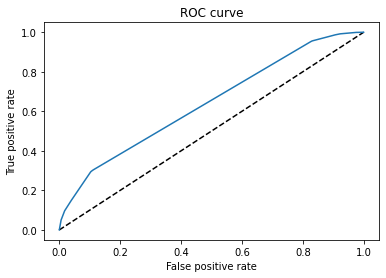

In [102]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig(path+'data/output/decision_tree/ROC.png')
plt.show()

## visualize results

In [103]:
text_representation = tree.export_text(model)

In [104]:
reverse_vocab = {idx:word for word, idx in vectorizer.vocabulary_.items()}

In [105]:
# reverse_vocab[:100]

In [106]:
print(text_representation[:800])

|--- feature_8610 <= 0.50
|   |--- feature_5517 <= 0.50
|   |   |--- feature_7403 <= 0.50
|   |   |   |--- feature_9894 <= 0.50
|   |   |   |   |--- feature_5102 <= 0.50
|   |   |   |   |   |--- feature_5962 <= 0.50
|   |   |   |   |   |   |--- feature_3501 <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_3501 >  0.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- feature_5962 >  0.50
|   |   |   |   |   |   |--- feature_2977 <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_2977 >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5102 >  0.50
|   |   |   |   |   |--- feature_1211 <= 0.50
|   |   |   |   |   |   |--- feature_9641 <= 0.50
|   |   |   |   |   |   |   |---


In [74]:
import scipy
not_check_list = [8610, 5517, 7403, 9894, 5102, 5962]

In [118]:
counter = 0
first_split_pos = []
for i in range(valid_BOW.shape[0]):
  row = valid_BOW[i]
  _ ,cols = row.nonzero()

  in_list = False
  for c in cols:
    # print(row[:, c].toarray()[0][0])
    if c in not_check_list:
      in_list=True
  
  # in line with the criteria, none of the words are present in this doc
  if not in_list:
    counter+=1

    # now check for 3501. if it's present, we assign class 2, else class 0
    if 3501 in cols:
      first_split_pos.append(i)
      

  

In [119]:
first_split_pos[:10]

[14, 18, 35, 41, 42, 63, 65, 67, 102, 110]

In [125]:
print(X_valid['text'].iloc[110])
print(y_valid.iloc[110])

tonight was my silly night of the year good night twitterhomies! haha
2


In [126]:
print(X_valid['text'].iloc[3])
print(y_valid.iloc[3])

today i realized i am a stalker. also the meaning of my nickname banana nutz
0


In [81]:
for idx in not_check_list:
  if idx in reverse_vocab:
    print(idx, reverse_vocab[idx])

reverse_vocab[3501]

8610 thank
5517 miss
7403 sad
9894 you
5102 love
5962 not


'good'

In [130]:
with open(path+"data/output/decision_tree/text_representation.txt", "w") as text_file:
  for line in text_representation.split('\n'):
    text_file.write(line+'\n')